# SkimLit: Skimming Literature with NLP

This notebook uses natural language processing techniques to analyze and classify sentences from scientific abstracts. The goal is to automate the extraction of important information from scientific papers, which is crucial for researchers and professionals who need to quickly review and understand the literature.

## Required Datasets

**PubMed 20k RCT Dataset**:

This notebook utilizes text files from the `PubMed_20k_RCT_numbers_replaced_with_at_sign` folder, which should be downloaded and stored in a `data` directory accessible by the notebook.

### How to Download Dataset

To access and set up the datasets, please follow these steps:

1. Create a `data` folder in your project directory if it doesn't already exist.
2. Download the text files from the following Kaggle dataset link:
   - [PubMed 20k RCT Dataset](https://www.kaggle.com/datasets/matthewjansen/pubmed-200k-rtc?select=PubMed_200k_RCT_numbers_replaced_with_at_sign) (ensure you comply with the dataset's usage rules).
3. Place the downloaded text files into the `data` folder. This step ensures that all data files are ready to be accessed by the notebook.

## Contents of the Notebook

- **Introduction**: Overview of the project's aim and importance.
- **Basic Exploratory Data Analysis**: Initial analysis of the data to understand the distribution and nature of the dataset.
- **Text Normalization**: Processing steps to clean and normalize the text data.
- **Model Building**: Implementation of various models to classify sentences in scientific abstracts.
- **Model Evaluation**: Evaluation of the models' performance using appropriate metrics.

 ## Install Required Packages

- To enhance the functionality of the CTPO environment, you may need to install some libraries not pre-installed but required for this notebook. Follow these steps to install the necessary libraries from the `requirements.txt` file:

 ### Create and Activate the Virtual Environment:
   
   Open your terminal or command prompt within the jupyter notebook. `File -> New -> Terminal`
   
   Navigate to the project directory where you want to set up the environment.
   
   Execute the following commands in a `bash` to create and activate the virtual environment:
   
   ```
   python3 -m venv --system-site-packages myvenv #myvenv is name of virtual environment you can change it
   source myvenv/bin/activate
   pip3 install ipykernel
   python -m ipykernel install --user --name=myvenv --display-name="Python (myvenv)"
   ```

### Important Note

It is crucial to load the new "myvenv" kernel for the notebook to work correctly. If the new "myvenv" kernel is not loaded, the required libraries and environment settings will not be applied, and the notebook will not function as expected.

 ### Install Required Libraries
   
   Before running the following command in jupyter notebook, make sure you are in the directory where the Jupyter Notebook and virtual environment is located. This ensures the ./ path is always current. You can use the cd command to change to your project directory and pwd to verify your current directory.
   

In [47]:
!. ./myvenv/bin/activate; pip install --no-deps -r requirements.txt

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as tfhub
import os
import random
import string
from helper_functions import *
from sklearn.preprocessing import *
from sklearn.feature_extraction.text import *
from sklearn.naive_bayes import *
from sklearn.pipeline import *

In [48]:
LOGS_DIR = 'logs/'

In [49]:
data_dir_path = './data/'
train_dir_path = data_dir_path + 'train.txt'
test_dir_path = data_dir_path + 'test.txt'
validation_dir_path = data_dir_path + 'dev.txt'

In [50]:
filenames = [data_dir_path + filename for filename in os.listdir(data_dir_path)]
filenames

['./data/train.txt', './data/dev.txt', './data/test.txt']

In [51]:
def read_doc(filename):
  """
  Reads filename (txt) and returns the lines of text as a list

  Args:

    filename: A string containing the target filepath

  Returns:

    A list of strings with one string per line from the target filename
  """
  with open(filename, 'r') as f:
    return f.readlines()


In [52]:
train_lines = read_doc(train_dir_path)
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [53]:
def preprocess_doc(filename):
  """
  Returns a list of dictionaries for each line relating to one abstract, doing the same for all abstracts

  Args:

    filename: A string which is the path of the doc

  Returns:

    A list of dictionaries with preprocesse data from the doc
  """
  input_lines = read_doc(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        label_text_split = abstract_line.split('\t')
        line_data['line_number'] = abstract_line_number
        line_data['label'] = label_text_split[0]
        line_data['text'] = label_text_split[1].lower()
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line

  return abstract_samples

In [54]:
train_samples = preprocess_doc(train_dir_path)
validation_samples = preprocess_doc(validation_dir_path)
test_samples = preprocess_doc(test_dir_path)
len(train_samples), len(validation_samples), len(test_samples)

(180040, 30212, 30135)

In [55]:
train_samples[:10]

[{'line_number': 0,
  'label': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'label': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'label': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'label': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'label': 'METHODS',
  'text': 'secondary outcome measures included the

In [56]:
train_df = pd.DataFrame(train_samples)
validation_df = pd.DataFrame(validation_samples)
test_df = pd.DataFrame(test_samples)

In [57]:
train_df.head(10)

,line_number,label,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [58]:
train_df['label'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: label, dtype: int64

<Axes: ylabel='Frequency'>

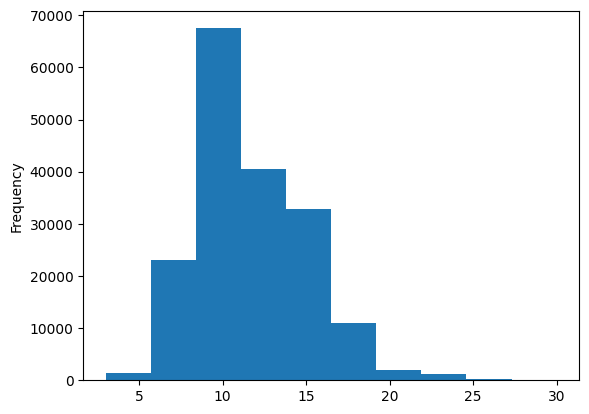

In [59]:
train_df['total_lines'].plot.hist()

In [60]:
train_sentences = train_df['text'].to_list()
validation_sentences = validation_df['text'].to_list()
test_sentences = test_df['text'].to_list()

In [61]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [62]:
one_hot_encoder = OneHotEncoder(sparse_output = False)
train_labels_one_hot_encoded = one_hot_encoder.fit_transform(train_df['label'].to_numpy().reshape(-1,1))
validation_labels_one_hot_encoded = one_hot_encoder.transform(validation_df['label'].to_numpy().reshape(-1,1))
test_labels_one_hot_encoded = one_hot_encoder.transform(test_df['label'].to_numpy().reshape(-1,1))

In [63]:
label_encoder = LabelEncoder()
train_labels_label_encoded = label_encoder.fit_transform(train_df['label'].to_numpy())
validation_labels_label_encoded = label_encoder.transform(validation_df['label'].to_numpy())
test_labels_label_encoded = label_encoder.transform(test_df['label'].to_numpy())

In [64]:
total_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
total_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [65]:
baseline_model = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

baseline_model.fit(X = train_sentences,
                   y = train_labels_label_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [66]:
baseline_model.score(X = validation_sentences,
                     y = validation_labels_label_encoded)

0.7218323844829869

In [67]:
baseline_preds = baseline_model.predict(validation_sentences)
baseline_results = calculate_results(y_true = validation_labels_label_encoded,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [68]:
sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
average_sentence_length = np.mean(sentence_lengths)
average_sentence_length

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

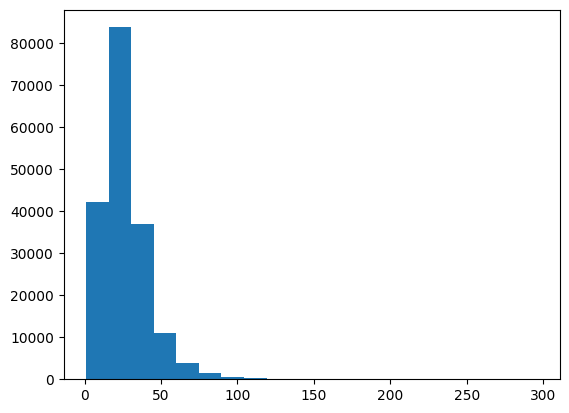

In [69]:
plt.hist(sentence_lengths, bins = 20)

In [70]:
output_sentence_length = int(np.percentile(sentence_lengths, 95))
output_sentence_length

55

In [71]:
max_tokens = 68000

In [72]:
token_vectorizer = tf.keras.layers.TextVectorization(max_tokens = max_tokens,
                                                                               output_sequence_length = output_sentence_length)

In [73]:
token_vectorizer.adapt(train_sentences)

In [74]:
sample_sentence = random.choice(train_sentences)
print(f'Text:\n{sample_sentence}')
print(f'\nLength of sentence: {len(sample_sentence.split())}')
print(f'\nVectorized text: {token_vectorizer([sample_sentence])}')

Text:
patients with kras exon @ wild-type resectable or suboptimally resectable colorectal liver metastases were randomised in a @:@ ratio to receive chemotherapy with or without cetuximab before and after liver resection .

Length of sentence: 32

Vectorized text: [[   12     7  2969  5507  3888  7300    16 13658  7300  1264   604  1792
      9   210     5     8   166     6   175   415     7    16   159  2028
    129     3    21   604   814     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [75]:
token_vocab = token_vectorizer.get_vocabulary()
print(f'Number of words in token_vocab: {len(token_vocab)}')
print(f'Most common words in token_vocab: {(token_vocab[:10])}')
print(f'Least common words in token_vocab: {(token_vocab[-10:])}')

Number of words in token_vocab: 64841
Most common words in token_vocab: ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
Least common words in token_vocab: ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [76]:
token_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'float32',
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [77]:
token_embedder = tf.keras.layers.Embedding(input_dim = len(token_vocab),
                                          output_dim = 128,
                                          mask_zero = True,
                                          name = 'token_embedding_layer')

In [78]:
print(f'Sentence:\n {sample_sentence}\n')
vectorized_sample_sentence = token_vectorizer([sample_sentence])
print(f'Vectorized sentence:\n{vectorized_sample_sentence}\n')
embedded_sample_sentence = token_embedder(vectorized_sample_sentence)
print(f'Embedded sentence:\n{embedded_sample_sentence}\n')

Sentence:
 patients with kras exon @ wild-type resectable or suboptimally resectable colorectal liver metastases were randomised in a @:@ ratio to receive chemotherapy with or without cetuximab before and after liver resection .

Vectorized sentence:
[[   12     7  2969  5507  3888  7300    16 13658  7300  1264   604  1792
      9   210     5     8   166     6   175   415     7    16   159  2028
    129     3    21   604   814     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Embedded sentence:
[[[ 0.03176648  0.04390932  0.00976849 ...  0.02336836 -0.02101143
    0.03519324]
  [ 0.02517966 -0.03575716 -0.00675922 ... -0.00301816 -0.000521
    0.04117246]
  [-0.03972762  0.01380021 -0.04318367 ...  0.02390124  0.02925087
    0.04898418]
  ...
  [-0.01369909 -0.00310749  0.04501036 ...  0.01590249 -0.02598536
   -0.04867996]
  [-0.01369909 -0.00310749  0.04501036 ...  0.01590

In [79]:
train_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot_encoded))
validation_token_data = tf.data.Dataset.from_tensor_slices((validation_sentences, validation_labels_one_hot_encoded))
test_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot_encoded))

In [80]:
train_token_data = train_token_data.batch(32).prefetch(tf.data.AUTOTUNE)
validation_token_data = validation_token_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_token_data = test_token_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
inputs = tf.keras.layers.Input(shape = (1,), dtype = tf.string)
text_vectors = token_vectorizer(inputs)
text_embeddings = token_embedder(text_vectors)
x = tf.keras.layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(text_embeddings)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(total_classes, activation = 'softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name = 'conv1d_20k')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:873: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [82]:
model_1.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003),
                metrics = ['accuracy'])

In [83]:
model_1_history = model_1.fit(train_token_data,
                              epochs = 5,
                              steps_per_epoch = int(0.25 * len(train_token_data)),
                              validation_data = validation_token_data,
                              validation_steps = int(0.25 * len(validation_token_data)),
                              callbacks=[create_tensorboard_callback(dir_name = LOGS_DIR, experiment_name = 'conv1d_20k')])

Saving TensorBoard log files to: logs//conv1d_20k/20240726-201607
Epoch 1/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 46s 32ms/step - accuracy: 0.6702 - loss: 0.8372 - val_accuracy: 0.7895 - val_loss: 0.5822
Epoch 2/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - accuracy: 0.7939 - loss: 0.5739 - val_accuracy: 0.8095 - val_loss: 0.5267
Epoch 3/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 46s 33ms/step - accuracy: 0.8001 - loss: 0.5559 - val_accuracy: 0.8162 - val_loss: 0.5148
Epoch 4/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 44s 31ms/step - accuracy: 0.8120 - loss: 0.5267 - val_accuracy: 0.8048 - val_loss: 0.5558
Epoch 5/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 119us/step - accuracy: 0.7917 - loss: 0.6702 - val_accuracy: 1.0000 - val_loss: 0.1134


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-26 20:19:10.621173: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [84]:
model_1.evaluate(validation_token_data)

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8047 - loss: 0.5302


[0.5324324369430542, 0.8090493679046631]

In [85]:
model_1_preds = tf.argmax(model_1.predict(validation_token_data), axis = 1)
model_1_preds, validation_labels_one_hot_encoded

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


(<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>,
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]))

In [86]:
model_1_results = calculate_results(y_true = validation_labels_label_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 80.90493843505891,
 'precision': 0.8146089890673979,
 'recall': 0.8090493843505892,
 'f1': 0.8041147663755502}

In [105]:
use_layer = tfhub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", trainable=False)

In [106]:
print(f'Sentence:\n {sample_sentence}\n')
use_sample_sentence = use_layer([sample_sentence])
print(f'Embedded sentence:\n{use_sample_sentence}\n')

Sentence:
 patients with kras exon @ wild-type resectable or suboptimally resectable colorectal liver metastases were randomised in a @:@ ratio to receive chemotherapy with or without cetuximab before and after liver resection .

Embedded sentence:
[[-0.05194866 -0.04528489  0.00060979 -0.02213926 -0.01749174 -0.07387634
  -0.00661172 -0.02403653  0.00041338  0.04581341  0.08231939 -0.05794041
  -0.00318274 -0.00498147 -0.05804063 -0.03017569 -0.08290515 -0.06334894
  -0.03981418  0.04129298  0.08207209  0.06941615 -0.01186943 -0.02327424
  -0.01360889  0.04043709  0.01248823 -0.03840219 -0.02614185  0.06304611
  -0.00484863  0.08289432 -0.05983064 -0.01420325 -0.06714552  0.05646594
   0.03230911 -0.05136216  0.06365643 -0.08169372  0.04076364  0.06920592
  -0.00391963 -0.02814033  0.05068073  0.07512772  0.00556877 -0.00524614
   0.01501312  0.03365798 -0.04532109 -0.01837858 -0.05132447 -0.05006457
   0.0348931   0.03439472 -0.06273325  0.02033362 -0.02426836  0.00100933
   0.003440

In [108]:
inputs = tf.keras.layers.Input(shape=[], name="Input", dtype=tf.string)
text_use_embedding = tf.keras.layers.Lambda(lambda x: use_layer(x), output_shape=(512,))(inputs)
x = tf.keras.layers.Dense(128, activation = 'relu')(text_use_embedding)
outputs = tf.keras.layers.Dense(total_classes, activation = 'softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name = 'use_20k')

In [109]:
model_2.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003),
                metrics = ['accuracy'])

In [110]:
model_2_history = model_2.fit(train_token_data,
                              epochs = 5,
                              steps_per_epoch = int(0.25 * len(train_token_data)),
                              validation_data = validation_token_data,
                              validation_steps = int(0.25 * len(validation_token_data)),
                              callbacks = [create_tensorboard_callback(dir_name = LOGS_DIR, experiment_name = 'use_20k')])

Saving TensorBoard log files to: logs//use_20k/20240726-210656
Epoch 1/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.6642 - loss: 0.8630 - val_accuracy: 0.7274 - val_loss: 0.7051
Epoch 2/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - accuracy: 0.7360 - loss: 0.6873 - val_accuracy: 0.7460 - val_loss: 0.6510
Epoch 3/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - accuracy: 0.7424 - loss: 0.6711 - val_accuracy: 0.7656 - val_loss: 0.6143
Epoch 4/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.7536 - loss: 0.6459 - val_accuracy: 0.7534 - val_loss: 0.6562
Epoch 5/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 95us/step - accuracy: 0.7500 - loss: 0.7341 - val_accuracy: 0.7500 - val_loss: 0.5824


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [111]:
model_2.evaluate(validation_token_data)

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7600 - loss: 0.6293


[0.6283352971076965, 0.7603270411491394]

In [112]:
model_2_preds = tf.argmax(model_2.predict(validation_token_data), axis = 1)

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step


In [113]:
model_2_results = calculate_results(y_true = validation_labels_label_encoded,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 76.0327022375215,
 'precision': 0.7563483165058491,
 'recall': 0.7603270223752151,
 'f1': 0.7561004055293974}

In [114]:
def split_chars(text):
  return ' '.join(list(text))

In [115]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
validation_chars = [split_chars(sentence) for sentence in validation_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [116]:
character_lengths = [len(sentence) for sentence in train_sentences]
average_character_length = np.mean(character_lengths)
average_character_length

149.3662574983337

(array([1.69034e+05, 1.07780e+04, 2.09000e+02, 1.60000e+01, 3.00000e+00]),
 array([1.000e+00, 2.780e+02, 5.550e+02, 8.320e+02, 1.109e+03, 1.386e+03]),
 <BarContainer object of 5 artists>)

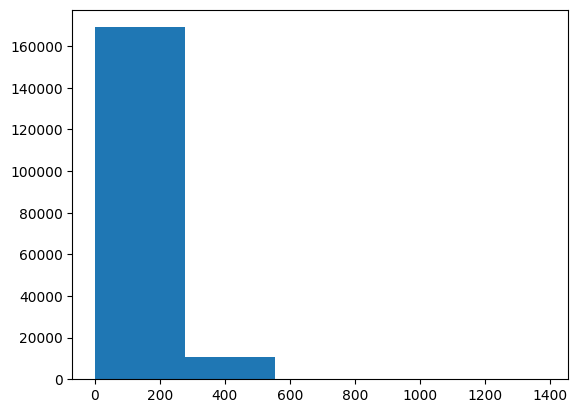

In [117]:
plt.hist(character_lengths, bins = 5)

In [118]:
output_character_length = int(np.percentile(character_lengths, 95))
output_character_length

290

In [119]:
characters = string.ascii_lowercase + string.digits + string.punctuation
characters

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [120]:
max_chars = len(characters) +2
max_chars

70

In [121]:
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = max_chars,
                                                    output_sequence_length = output_character_length,
                                                    name = 'character_vectorizer_layer')

In [122]:
char_vectorizer.adapt(train_chars)

2024-07-26 21:10:04.002647: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 504080352 exceeds 10% of free system memory.


In [123]:
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of words in char_vocab: {len(char_vocab)}')
print(f'Most common words in char_vocab: {(char_vocab[:10])}')
print(f'Least common words in char_vocab: {(char_vocab[-10:])}')

Number of words in char_vocab: 28
Most common words in char_vocab: ['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's']
Least common words in char_vocab: ['g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']


In [124]:
char_vectorizer.get_config()

{'name': 'character_vectorizer_layer',
 'trainable': True,
 'dtype': 'float32',
 'max_tokens': 70,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 290,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 28}

In [125]:
char_embedder = tf.keras.layers.Embedding(input_dim = len(char_vocab),
                                               output_dim = 25,
                                               mask_zero = True,
                                               name = 'character_embedder_layer')

In [126]:
sample_chars = split_chars(sample_sentence)
print(f'Sentence:\n {sample_chars}\n')
vectorized_sample_chars = char_vectorizer([sample_chars])
print(f'Vectorized sentence:\n{vectorized_sample_chars}\n')
embedded_sample_chars = char_embedder(vectorized_sample_chars)
print(f'Embedded sentence:\n{embedded_sample_chars}\n')

Sentence:
 p a t i e n t s   w i t h   k r a s   e x o n   @   w i l d - t y p e   r e s e c t a b l e   o r   s u b o p t i m a l l y   r e s e c t a b l e   c o l o r e c t a l   l i v e r   m e t a s t a s e s   w e r e   r a n d o m i s e d   i n   a   @ : @   r a t i o   t o   r e c e i v e   c h e m o t h e r a p y   w i t h   o r   w i t h o u t   c e t u x i m a b   b e f o r e   a n d   a f t e r   l i v e r   r e s e c t i o n   .

Vectorized sentence:
[[14  5  3  4  2  6  3  9 20  4  3 13 23  8  5  9  2 24  7  6 20  4 12 10
   3 19 14  2  8  2  9  2 11  3  5 22 12  2  7  8  9 16 22  7 14  3  4 15
   5 12 12 19  8  2  9  2 11  3  5 22 12  2 11  7 12  7  8  2 11  3  5 12
  12  4 21  2  8 15  2  3  5  9  3  5  9  2  9 20  2  8  2  8  5  6 10  7
  15  4  9  2 10  4  6  5  8  5  3  4  7  3  7  8  2 11  2  4 21  2 11 13
   2 15  7  3 13  2  8  5 14 19 20  4  3 13  7  8 20  4  3 13  7 16  3 11
   2  3 16 24  4 15  5 22 22  2 17  7  8  2  5  6 10  5 17  3  2  8 12  4
  21  2  8  8  

In [127]:
inputs = tf.keras.layers.Input(shape = (1, ), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embedder(char_vectors)
x = tf.keras.layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(char_embeddings)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(total_classes, activation = 'softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name = 'conv1d_char_20k')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:873: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [128]:
model_3.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003),
                metrics = ['accuracy'])

In [129]:
train_char_data = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot_encoded))
validation_char_data = tf.data.Dataset.from_tensor_slices((validation_chars, validation_labels_one_hot_encoded))
test_char_data = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot_encoded))

In [130]:
train_char_data = train_char_data.batch(32).prefetch(tf.data.AUTOTUNE)
validation_char_data = validation_char_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_data = test_char_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [131]:
model_3_history = model_3.fit(train_char_data,
                              epochs = 5,
                              steps_per_epoch = int(0.25 * len(train_char_data)),
                              validation_data = validation_char_data,
                              validation_steps = int(0.25 * len(validation_char_data)),
                              callbacks = [create_tensorboard_callback(dir_name = LOGS_DIR, experiment_name = 'conv1d_char_20k')])


Saving TensorBoard log files to: logs//conv1d_char_20k/20240726-211007
Epoch 1/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.3870 - loss: 1.3986 - val_accuracy: 0.5026 - val_loss: 1.2212
Epoch 2/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.5003 - loss: 1.2110 - val_accuracy: 0.5466 - val_loss: 1.1222
Epoch 3/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.5478 - loss: 1.1111 - val_accuracy: 0.5889 - val_loss: 1.0269
Epoch 4/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.5918 - loss: 1.0270 - val_accuracy: 0.5720 - val_loss: 1.0595
Epoch 5/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - accuracy: 0.5694 - loss: 1.0249 - val_accuracy: 0.5000 - val_loss: 0.9676


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-26 21:11:13.974980: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [132]:
model_3.evaluate(validation_char_data)

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6184 - loss: 0.9595


[0.9632526636123657, 0.6185290813446045]

In [133]:
model_3_preds = tf.argmax(model_3.predict(validation_char_data), axis = 1)

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


In [134]:
model_3_results = calculate_results(y_true = validation_labels_label_encoded,
                                    y_pred = model_3_preds)
model_3_results

{'accuracy': 61.85290613001456,
 'precision': 0.5999025018464338,
 'recall': 0.6185290613001456,
 'f1': 0.5937408914538367}

In [160]:
token_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name='token_input')
token_embeddings = tf.keras.layers.Lambda(lambda x: use_layer(x), output_shape=(512,))(token_inputs)
token_outputs = tf.keras.layers.Dense(256, activation='relu', name='token_output')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name='token_model')


In [161]:
# Define the char input model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedder(char_vectors)
char_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24), name='char_output')(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_outputs, name='char_model')

In [162]:
token_char_inputs = tf.keras.layers.Concatenate(name='token_char_input')([token_model.output, char_model.output])


In [163]:
token_char_dropout_1 = tf.keras.layers.Dropout(0.5, name='token_char_dropout_1')(token_char_inputs)
token_char_dense = tf.keras.layers.Dense(128, activation='relu', name='token_char_dense')(token_char_dropout_1)
token_char_dropout_2 = tf.keras.layers.Dropout(0.5, name='token_char_dropout_2')(token_char_dense)
token_char_outputs = tf.keras.layers.Dense(total_classes, activation='softmax', name='token_char_output')(token_char_dropout_2)


In [164]:
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=token_char_outputs, name='token_char_20k')


In [165]:
tf.keras.utils.plot_model(model_4, show_shapes = True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [166]:
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot_encoded)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))

validation_token_char_data = tf.data.Dataset.from_tensor_slices((validation_sentences, validation_chars))
validation_token_char_labels = tf.data.Dataset.from_tensor_slices(validation_labels_one_hot_encoded)
validation_token_char_dataset = tf.data.Dataset.zip((validation_token_char_data, validation_token_char_labels))


In [167]:
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
validation_token_char_dataset = validation_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [168]:
model_4.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    metrics=['accuracy']
)

In [169]:
model_4_history = model_4.fit(
    train_token_char_dataset,
    epochs=5,
    steps_per_epoch=int(0.25 * len(train_token_char_dataset)),
    validation_data=validation_token_char_dataset,
    validation_steps=int(0.25 * len(validation_token_char_dataset)),
    callbacks=[create_tensorboard_callback(dir_name=LOGS_DIR, experiment_name='token_char_20k')]
)

Saving TensorBoard log files to: logs//token_char_20k/20240726-213526
Epoch 1/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 262s 182ms/step - accuracy: 0.6378 - loss: 0.9181 - val_accuracy: 0.7275 - val_loss: 0.7014
Epoch 2/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 256s 182ms/step - accuracy: 0.7153 - loss: 0.7529 - val_accuracy: 0.7558 - val_loss: 0.6408
Epoch 3/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 258s 184ms/step - accuracy: 0.7201 - loss: 0.7368 - val_accuracy: 0.7680 - val_loss: 0.6106
Epoch 4/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 254s 181ms/step - accuracy: 0.7315 - loss: 0.7149 - val_accuracy: 0.7611 - val_loss: 0.6390
Epoch 5/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1s 294us/step - accuracy: 0.6806 - loss: 0.7757 - val_accuracy: 0.7500 - val_loss: 0.6338


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [170]:
model_4.evaluate(validation_token_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.7646 - loss: 0.6260


[0.6219335198402405, 0.7670131325721741]

In [171]:
model_4_preds = tf.argmax(model_4.predict(validation_token_char_dataset), axis = 1)

945/945 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step


In [172]:
model_4_results = calculate_results(y_true = validation_labels_label_encoded,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 76.70131073745532,
 'precision': 0.7633596713633759,
 'recall': 0.7670131073745532,
 'f1': 0.7619081127188838}

<Axes: ylabel='Frequency'>

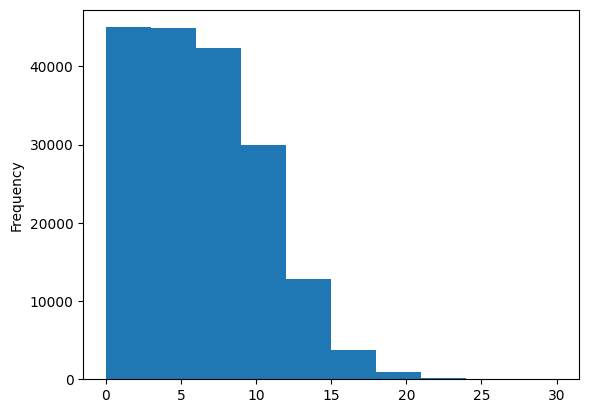

In [173]:
train_df['line_number'].plot.hist()

In [174]:
train_line_numbers_one_hot_encoded = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
validation_line_numbers_one_hot_encoded = tf.one_hot(validation_df['line_number'].to_numpy(), depth = 15)
test_line_numbers_one_hot_encoded = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)

<Axes: ylabel='Frequency'>

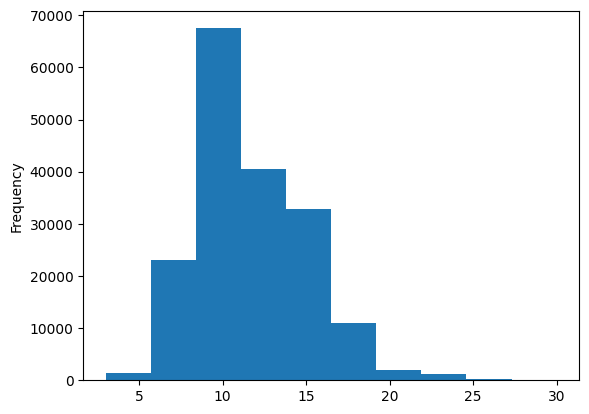

In [175]:
train_df['total_lines'].plot.hist()

In [176]:
train_total_lines_one_hot_encoded = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
validation_total_lines_one_hot_encoded = tf.one_hot(validation_df['total_lines'].to_numpy(), depth = 20)
test_total_lines_one_hot_encoded = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 20)

In [177]:
line_number_inputs = tf.keras.layers.Input(shape = (15, ), dtype = tf.float32, name = 'line_number_input')
line_number_outputs = tf.keras.layers.Dense(32, activation = 'relu', name = 'line_number_output')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

In [178]:
total_lines_inputs = tf.keras.layers.Input(shape = (20, ), dtype = tf.float32, name = 'total_lines_input')
total_lines_outputs = tf.keras.layers.Dense(32, activation = 'relu', name = 'total_line_output')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs, name = 'total_lines_model')

In [179]:
token_char_dense = tf.keras.layers.Dense(256, activation = 'relu', name = 'token_char_dense')(token_char_inputs)
token_char_dropout = tf.keras.layers.Dropout(0.5, name = 'token_char_dropout')(token_char_dense)
token_char_positional_inputs = tf.keras.layers.Concatenate(name = 'token_char_positional_inputs')([line_number_model.output,
                                                                                                   total_lines_model.output,
                                                                                                   token_char_dropout])
token_char_positional_outputs = tf.keras.layers.Dense(total_classes, activation = 'softmax', name = 'token_char_positional_output')(token_char_positional_inputs)
model_5 = tf.keras.Model([line_number_model.input,
                          total_lines_model.input,
                          token_model.input,
                          char_model.input],
                         token_char_positional_outputs)

In [180]:
tf.keras.utils.plot_model(model_5)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [181]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.003),
                metrics = ['accuracy'])

In [182]:
train_token_char_positional_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot_encoded, train_total_lines_one_hot_encoded, train_sentences, train_chars))
train_token_char_positional_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot_encoded)
train_token_char_positional_dataset = tf.data.Dataset.zip((train_token_char_positional_data, train_token_char_positional_labels))
validation_token_char_positional_data = tf.data.Dataset.from_tensor_slices((validation_line_numbers_one_hot_encoded, validation_total_lines_one_hot_encoded, validation_sentences, validation_chars))
validation_token_char_positional_labels = tf.data.Dataset.from_tensor_slices(validation_labels_one_hot_encoded)
validation_token_char_positional_dataset = tf.data.Dataset.zip((validation_token_char_positional_data, validation_token_char_positional_labels))

In [183]:
train_token_char_positional_dataset = train_token_char_positional_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
validation_token_char_positional_dataset = validation_token_char_positional_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [184]:
model_5_history = model_5.fit(train_token_char_positional_dataset,
                              epochs = 5,
                              steps_per_epoch = int(0.25 * len(train_token_char_positional_dataset)),
                              validation_data = validation_token_char_positional_dataset,
                              validation_steps = int(0.25 * len(validation_token_char_positional_dataset)),
                              callbacks = [create_tensorboard_callback(dir_name = LOGS_DIR, experiment_name = 'token_char_positional_20k')])

Saving TensorBoard log files to: logs//token_char_positional_20k/20240726-215424
Epoch 1/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 263s 183ms/step - accuracy: 0.7939 - loss: 1.0033 - val_accuracy: 0.8460 - val_loss: 0.9236
Epoch 2/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 249s 177ms/step - accuracy: 0.8422 - loss: 0.9303 - val_accuracy: 0.8563 - val_loss: 0.9004
Epoch 3/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 254s 181ms/step - accuracy: 0.8451 - loss: 0.9297 - val_accuracy: 0.8614 - val_loss: 0.9070
Epoch 4/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 253s 180ms/step - accuracy: 0.8472 - loss: 0.9247 - val_accuracy: 0.8464 - val_loss: 0.9100
Epoch 5/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 1s 306us/step - accuracy: 0.7639 - loss: 1.0307 - val_accuracy: 0.7500 - val_loss: 0.8133


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [185]:
model_5.evaluate(validation_token_char_positional_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.8509 - loss: 0.9067


[0.9049688577651978, 0.8517807722091675]

In [186]:
model_5_preds = tf.argmax(model_5.predict(validation_token_char_positional_dataset), axis = 1)

945/945 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step


In [187]:
model_5_results = calculate_results(y_true = validation_labels_label_encoded,
                                    y_pred = model_5_preds)
model_5_results

{'accuracy': 85.17807493711108,
 'precision': 0.8528839542063553,
 'recall': 0.8517807493711108,
 'f1': 0.8477051303092041}

In [189]:
all_models_results = pd.DataFrame({
    'naive_bayes_model': baseline_results,
    'token_model': model_1_results,
    'use_model': model_2_results,
    'char_model': model_3_results,
    'token_char_model': model_4_results,
    'token_char_positional_model': model_5_results
})

all_models_results = all_models_results.transpose()
all_models_results.reset_index(inplace = True)
all_models_results

,index,accuracy,precision,recall,f1
0,naive_bayes_model,72.183238,0.718647,0.721832,0.698925
1,token_model,80.904938,0.814609,0.809049,0.804115
2,use_model,76.032702,0.756348,0.760327,0.756100
3,char_model,61.852906,0.599903,0.618529,0.593741
4,token_char_model,76.701311,0.763360,0.767013,0.761908
5,token_char_positional_model,85.178075,0.852884,0.851781,0.847705


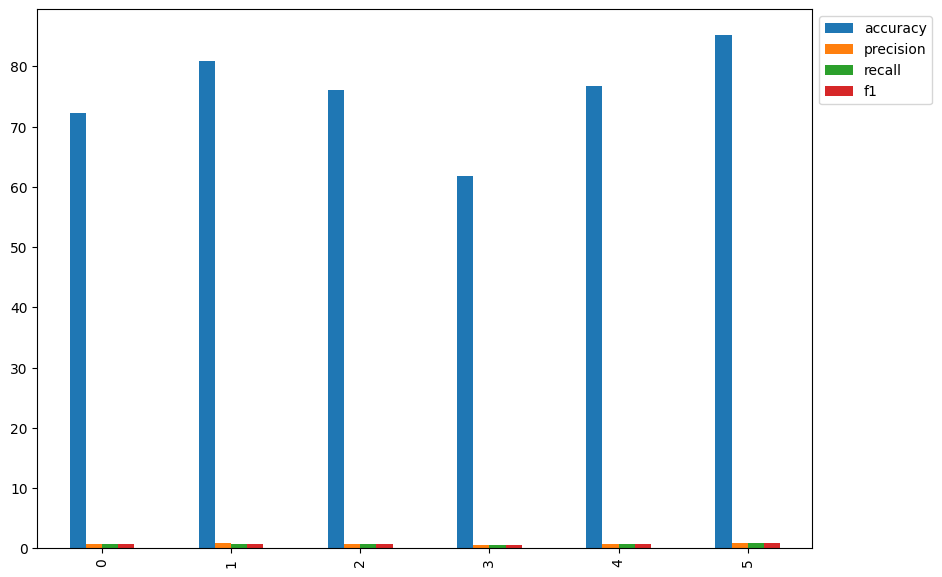

In [190]:
all_models_results.plot(kind = 'bar', figsize = (10,7)).legend(bbox_to_anchor = (1.0,1.0))

In [191]:
test_token_char_positional_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot_encoded, test_total_lines_one_hot_encoded, test_sentences, test_chars))
test_token_char_positional_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot_encoded)
test_token_char_positional_dataset = tf.data.Dataset.zip((test_token_char_positional_data, test_token_char_positional_labels))
test_token_char_positional_dataset = test_token_char_positional_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [192]:
model_5_test_preds = tf.argmax(model_5.predict(test_token_char_positional_dataset), axis = 1)

942/942 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step


In [193]:
model_5_test_results = calculate_results(y_true = test_labels_label_encoded,
                                         y_pred = model_5_test_preds)

In [194]:
model_5_test_results

{'accuracy': 84.65903434544549,
 'precision': 0.8467828093433831,
 'recall': 0.8465903434544549,
 'f1': 0.8424060813861306}